# ESG Scores and Financial Performance Across Industries: A Focus on the Consumer Goods Sector

**Team Members:**  
Menghan Liu, Yicheng Song, Jenny Zhu

This notebook explores how Environmental, Social, and Governance (ESG) scores relate to financial performance across industries, 
focusing particularly on the Consumer Goods sector. The analysis combines financial and sustainability data from Yahoo Finance 
and sectoral classification from Wikipedia.

Our goal is to explore and try to answer the central question " Whether industries with stronger ESG practices exhibit different financial and risk characteristics and, within the consumer sector, how ESG patterns differ among subsectors."


There are two main central hypotheses as guidance:
1. **H1:** Higher Governance Score → Higher Profitability (ROE).  
2. **H2:** Higher Environment Score → Lower Market Risk (Beta).


---

## Overview of Notebook Sections

1. **Import Libraries** – Bring in dependencies for data collection, cleaning, visualization, and analysis.  
2. **Data Collection** – Scrape S&P 500 tickers and fetch Yahoo Finance fundamentals and ESG data.  
3. **Data Cleaning & Merging** – Handle missing values, normalize metrics, and prepare final datasets.  
4. **Exploratory Data Analysis (EDA)(On Sector level)** – Generate plots to visualize ESG and financial patterns.  
5. **Exploratory Data Analysis (EDA)(Consumer Sector Zoomed-in)** – Generate plots to visualize ESG and financial patterns.  
6. **Statistical Tests & Regression** – Test hypotheses with Kruskal–Wallis, Spearman correlation, and OLS.  
7. **Consumer Sub-Sector (Industries) Focus** – Zoom in on the Consumer Goods sector to analyze ESG disclosure patterns and intra-sector variability regarding different industries within the consumer sector
8. **Conclusion** – Explain what the findings are

---

### Library Purpose Overview

| Library | Purpose |
|----------|----------|
| pandas | Data manipulation and cleaning |
| numpy | Numerical computation |
| yfinance | Retrieve financial and sustainability data |
| requests | Web scraping for tickers and screeners |
| matplotlib / seaborn | Visualization |
| statsmodels | Regression and statistical analysis |
| scipy.stats | Kruskal–Wallis and Spearman tests |
| tqdm | Progress tracking during data fetching |
| time / os | API pacing and configuration |



## 1. Import Libraries

This section imports all necessary libraries for data collection, analysis, and visualization.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import kruskal, spearmanr
import yfinance as yf
import requests
from tqdm import tqdm
import time
import os


## 2. Data Collection

We fetch S&P 500 tickers from Wikipedia and pull financial + ESG data from Yahoo Finance.

In [5]:
#PAUSE_SECONDS and PAUSE help manage request pacing to avoid being rate-limited.
#MAX_TICKERS lets you limit how many tickers to process (for testing or performance reasons).
PAUSE_SECONDS = 0.4
PAUSE = 0.35
MAX_TICKERS = None

### 2.1 Data for the S&P 500 ---- analysis across industries(sector in our analysis)

In [6]:
def get_sp500_tickers():
    """
    Fetches the list of all S&P 500 ticker symbols from Wikipedia.
    """
    wiki = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"  # Wikipedia source
    headers = {"User-Agent": "Mozilla/5.0"}                             # Header to mimic a browser
    response = requests.get(wiki, headers=headers)                      # Send HTTP GET request
    from io import StringIO
    tables = pd.read_html(StringIO(response.text))                      # Parse HTML tables using pandas
    df = tables[0]                                                      # First table contains the S&P 500 list
    tickers = df['Symbol'].astype(str).tolist()                         # Extract ticker symbols
    tickers = [t.replace('.', '-') for t in tickers]                    # Replace '.' with '-' for Yahoo Finance compatibility
    return tickers                                                      # Return clean list of tickers



In [7]:
def get_sustainability_scores(sustainability_df):
    """
    Extracts ESG (Environmental, Social, Governance) scores from Yahoo Finance’s sustainability data.
    Handles variations in column naming conventions and missing data.
    """
    # Default output with NaN values
    out = {'environmentScore': np.nan, 'governanceScore': np.nan, 'totalEsg': np.nan}
    
    if sustainability_df is None:  # If no data available, return NaNs
        return out
    
    try:
        s = sustainability_df.iloc[:, 0]  # Take first column (contains ESG metrics)
        
        # Helper to find numeric values given possible column name variations
        def find_val(names):
            for n in names:
                if n in s.index:
                    try:
                        return float(s[n])  # Convert found value to float
                    except:
                        return np.nan
            return np.nan
        
        # Search for each ESG score using possible name variations
        out['environmentScore'] = find_val(['environmentScore','environment Risk Score','Environment Risk Score'])
        out['governanceScore'] = find_val(['governanceScore','governance Risk Score','Governance Risk Score'])
        out['totalEsg'] = find_val(['totalEsg','Total ESG Risk Score','totalEsgScore','total ESG'])
    
    except Exception:
        pass  # If anything fails, just keep NaNs
    
    return out  # Return dictionary of ESG scores

In [8]:
def fetch_ticker_features(sym, pause=PAUSE_SECONDS):
    """
    Fetches detailed financial and ESG metrics for a given company ticker using yfinance.
    """
    # Initialize dictionary with placeholders
    base = {
        'symbol': sym, 'shortName': None, 'sector': None, 'industry': None,
        'marketCap': np.nan, 'marketCap_bil': np.nan, 'log_marketCap': np.nan,
        'beta': np.nan, 'forwardPE': np.nan, 'priceToBook': np.nan,
        'profitMargins': np.nan, 'returnOnEquity': np.nan,
        'environmentScore': np.nan, 'governanceScore': np.nan, 'totalEsg': np.nan
    }
    
    try:
        t = yf.Ticker(sym)                      # Create yfinance ticker object
        info = t.info or {}                     # Get company info dictionary (basic financial data)
        
        # Extract company identification info
        base['shortName'] = info.get('shortName')
        base['sector'] = info.get('sector')
        base['industry'] = info.get('industry')
        
        # Extract and calculate market cap metrics
        base['marketCap'] = info.get('marketCap', np.nan)
        if pd.notna(base['marketCap']):
            base['marketCap_bil'] = base['marketCap'] / 1e9             # Convert to billions
            base['log_marketCap'] = np.log1p(base['marketCap'])         # Log-transform for scaling
        
        # Extract valuation and profitability ratios
        base['beta'] = info.get('beta', np.nan)
        base['forwardPE'] = info.get('forwardPE', np.nan)
        base['priceToBook'] = info.get('priceToBook', np.nan)
        base['profitMargins'] = info.get('profitMargins', np.nan)
        base['returnOnEquity'] = info.get('returnOnEquity', np.nan)
        
        # Try to fetch sustainability data (ESG)
        try:
            sustainability = t.sustainability
        except:
            sustainability = None
        
        # Merge extracted ESG scores into base dictionary
        base.update(get_sustainability_scores(sustainability))
    
    except:
        pass  # Ignore errors and keep defaults (useful for missing tickers)
    
    time.sleep(pause)  # Respect API rate limits
    return base        # Return collected metrics for one ticker

In [9]:
def collect_sp500_features(max_tickers=MAX_TICKERS):
    """
    Collects financial and ESG features for all (or selected) S&P 500 companies.
    """
    tickers = get_sp500_tickers()                    # Get full S&P 500 ticker list
    if max_tickers is not None:
        tickers = tickers[:max_tickers]              # Limit for faster testing
    
    rows = []                                        # Store feature dictionaries here
    for sym in tqdm(tickers, desc="Fetching S&P500"):
        rows.append(fetch_ticker_features(sym))      # Fetch data for each ticker
    
    df = pd.DataFrame(rows)                          # Convert list of dicts to DataFrame
    
    # Ensure consistent column order and fill missing columns with NaN
    cols = ['symbol','shortName','sector','industry',
            'marketCap','marketCap_bil','log_marketCap',
            'beta','forwardPE','priceToBook',
            'profitMargins','returnOnEquity',
            'environmentScore','governanceScore','totalEsg']
    
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    
    return df[cols]                                  # Return clean and ordered dataset



In [10]:
# Load the data
df_all = collect_sp500_features(max_tickers=MAX_TICKERS)   
print("✅ Collected S&P500 data:", df_all)    

Fetching S&P500: 100%|██████████| 503/503 [07:27<00:00,  1.12it/s]

✅ Collected S&P500 data:     symbol                       shortName             sector  \
0      MMM                      3M Company        Industrials   
1      AOS          A.O. Smith Corporation        Industrials   
2      ABT             Abbott Laboratories         Healthcare   
3     ABBV                     AbbVie Inc.         Healthcare   
4      ACN                   Accenture plc         Technology   
..     ...                             ...                ...   
498    XYL                      Xylem Inc.        Industrials   
499    YUM               Yum! Brands, Inc.  Consumer Cyclical   
500   ZBRA  Zebra Technologies Corporation         Technology   
501    ZBH    Zimmer Biomet Holdings, Inc.         Healthcare   
502    ZTS                     Zoetis Inc.         Healthcare   

                                     industry     marketCap  marketCap_bil  \
0                               Conglomerates   91158224896      91.158225   
1              Specialty Industrial Ma

In [13]:
# Viewing our data
df_all

,symbol,shortName,sector,industry,marketCap,marketCap_bil,log_marketCap,beta,forwardPE,priceToBook,profitMargins,returnOnEquity,environmentScore,governanceScore,totalEsg
0,MMM,3M Company,Industrials,Conglomerates,91158224896,91.158225,25.235863,1.108,21.721520,19.696970,0.13700,0.72921,19.82,4.06,36.88
1,AOS,A.O. Smith Corporation,Industrials,Specialty Industrial Machinery,9674546176,9.674546,22.992764,1.303,16.963144,5.241023,0.13683,0.27603,10.35,5.60,28.11
2,ABT,Abbott Laboratories,Healthcare,Medical Devices,219889582080,219.889582,26.116391,0.696,24.484497,4.348604,0.31880,NaN,2.25,4.28,16.88
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General,403216924672,403.216925,26.722741,0.507,18.816982,-2194.711400,0.06451,1.12854,2.24,5.40,21.22
4,ACN,Accenture plc,Technology,Information Technology Services,154916896768,154.916897,25.766155,1.278,17.754797,4.979767,0.11021,0.25509,2.54,3.99,12.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Specialty Industrial Machinery,35949178880,35.949179,24.305372,1.128,31.092632,3.246148,0.10745,0.08625,9.53,3.26,20.57
499,YUM,"Yum! Brands, Inc.",Consumer Cyclical,Restaurants,40622895104,40.622895,24.427598,0.721,24.074013,-5.298270,0.18121,NaN,9.53,3.66,20.03
500,ZBRA,Zebra Technologies Corporation,Technology,Communication Equipment,15959785472,15.959785,23.493338,1.752,19.569202,4.411665,0.10559,0.15875,3.47,3.86,10.88
501,ZBH,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices,20435582976,20.435583,23.740543,0.667,11.995349,1.629957,0.10512,0.06529,4.24,5.32,24.09


### 2.2 Data for the Consumers (Consumer Defensive and Consumer Cyclical)---- analysis zoomed in consumer related companies

In [14]:
def get_consumer_tickers():
    """
    Fetches a list of consumer-sector company tickers from Yahoo Finance.
    Includes both 'Consumer Defensive' and 'Consumer Cyclical' categories.
    """
    tickers = set()  # Use a set to avoid duplicate tickers
    base_url = "https://query1.finance.yahoo.com/v1/finance/screener/predefined/saved"
    
    # Yahoo Finance predefined screener IDs for consumer sectors
    screens = ["ms_consumer_defensive", "ms_consumer_cyclical"]
    headers = {"User-Agent": "Mozilla/5.0"}  # Pretend to be a web browser
    
    for s in screens:
        offset = 0  # Pagination control for Yahoo API
        while True:
            # Construct the API query URL
            url = f"{base_url}?formatted=false&lang=en-US&region=US&scrIds={s}&start={offset}&count=100"
            try:
                resp = requests.get(url, headers=headers, timeout=10)  # Make HTTP request
                data = resp.json()  # Parse JSON response
                
                # Extract the list of quotes (stock tickers)
                quotes = data.get("finance", {}).get("result", [])[0].get("quotes", [])
                if not quotes:
                    break  # Stop if no more results
                
                # Add valid ticker symbols to our set
                new_tickers = [q.get("symbol") for q in quotes if q.get("symbol")]
                tickers.update(new_tickers)
                
                # Stop if fewer than 100 results (end of pagination)
                if len(quotes) < 100:
                    break
                offset += 100  # Move to next batch of results
            except:
                break  # Gracefully handle network or data errors
    
    print(f"✅ Pulled {len(tickers)} consumer tickers")
    return list(tickers)  # Return list of unique consumer tickers


In [15]:
def get_esg_scores(sustain_df):
    """
    Extracts ESG (Environmental, Governance, and Total) scores from
    a sustainability DataFrame returned by yfinance.
    """
    # Default output if data is missing or invalid
    out = {'environmentScore': np.nan, 'governanceScore': np.nan, 'totalEsg': np.nan}
    
    # Validate the input
    if sustain_df is None or not isinstance(sustain_df, pd.DataFrame):
        return out
    
    s = sustain_df.iloc[:, 0]  # Take first column, where ESG scores are usually stored
    
    # Helper function to look up multiple possible column names
    def find(klist):
        for k in klist:
            if k in s.index:
                try:
                    return float(s[k])  # Convert to numeric if possible
                except:
                    return np.nan
        return np.nan
    
    # Extract each ESG component with flexible naming
    out['environmentScore'] = find(['environmentScore', 'environmentRiskScore'])
    out['governanceScore'] = find(['governanceScore', 'governanceRiskScore'])
    out['totalEsg'] = find(['totalEsg', 'totalEsgScore', 'totalESG'])
    
    return out  # Return clean ESG score dictionary

In [16]:
def fetch_features(sym):
    """
    Fetches financial, valuation, profitability, and ESG metrics
    for a single company ticker using the yfinance API.
    """
    # Initialize default structure for all features
    base = {
        'symbol': sym, 'shortName': None, 'sector': None, 'industry': None,
        'marketCap': np.nan, 'marketCap_bil': np.nan, 'log_marketCap': np.nan,
        'beta': np.nan, 'forwardPE': np.nan, 'priceToBook': np.nan,
        'profitMargins': np.nan, 'returnOnEquity': np.nan,
        'environmentScore': np.nan, 'governanceScore': np.nan, 'totalEsg': np.nan
    }
    
    try:
        t = yf.Ticker(sym)             # Initialize Yahoo Finance ticker object
        info = t.info or {}            # Retrieve ticker info (financial data)
        
        # Basic descriptive fields
        base['shortName'] = info.get('shortName')
        base['sector'] = info.get('sector')
        base['industry'] = info.get('industry')
        
        # Market capitalization and transformations
        base['marketCap'] = info.get('marketCap', np.nan)
        if pd.notna(base['marketCap']):
            base['marketCap_bil'] = base['marketCap'] / 1e9          # Convert to billions
            base['log_marketCap'] = np.log1p(base['marketCap'])      # Log-transform
        
        # Financial and valuation ratios
        base['beta'] = info.get('beta', np.nan)
        base['forwardPE'] = info.get('forwardPE', np.nan)
        base['priceToBook'] = info.get('priceToBook', np.nan)
        base['profitMargins'] = info.get('profitMargins', np.nan)
        base['returnOnEquity'] = info.get('returnOnEquity', np.nan)
        
        # Attempt to retrieve ESG sustainability data
        try:
            sustain = t.sustainability
        except:
            sustain = None
        
        # Merge ESG scores into base dictionary
        base.update(get_esg_scores(sustain))
    
    except:
        pass  # Ignore tickers that fail to load
    
    time.sleep(PAUSE)  # Respect API rate limit
    return base        # Return all collected features for this ticker

In [17]:
#Batch Fetch Consumer Companies’ Data

tickers = get_consumer_tickers()  # Step 1: Get list of consumer tickers

rows = []
for sym in tqdm(tickers, desc="Fetching consumer companies"):
    rows.append(fetch_features(sym))  # Step 2: Fetch financial/ESG features per company

df_consumer_all = pd.DataFrame(rows)  # Step 3: Combine all rows into a single DataFrame

✅ Pulled 481 consumer tickers


Fetching consumer companies: 100%|██████████| 481/481 [07:19<00:00,  1.09it/s]


In [18]:
# Viewing our data
df_consumer_all

,symbol,shortName,sector,industry,marketCap,marketCap_bil,log_marketCap,beta,forwardPE,priceToBook,profitMargins,returnOnEquity,environmentScore,governanceScore,totalEsg
0,DOLE,Dole plc,Consumer Defensive,Farm Products,1.242824e+09,1.242824,20.940652,0.671,9.197184,0.902931,0.00276,0.09358,NaN,NaN,18.23
1,MOD,Modine Manufacturing Company,Consumer Cyclical,Auto Parts,7.999511e+09,7.999511,22.802646,2.057,32.151897,7.909897,0.07214,0.20871,NaN,NaN,24.83
2,THO,"Thor Industries, Inc.",Consumer Cyclical,Recreational Vehicles,5.738598e+09,5.738598,22.470481,1.347,16.877708,1.338136,0.02699,0.06136,13.19,5.47,32.13
3,PHIN,PHINIA Inc.,Consumer Cyclical,Auto Parts,2.114069e+09,2.114069,21.471880,1.394,11.488372,1.299378,0.03216,0.06402,NaN,NaN,NaN
4,EPC,Edgewell Personal Care Company,Consumer Defensive,Household & Personal Products,9.209213e+08,0.920921,20.640885,0.829,5.695402,0.587242,0.02940,0.04121,NaN,NaN,27.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,BBBY,"Bed Bath & Beyond, Inc.",None,None,5.208185e+08,0.520818,20.070912,NaN,NaN,3.688597,NaN,NaN,NaN,NaN,27.67
477,APEI,"American Public Education, Inc.",Consumer Defensive,Education & Training Services,6.466227e+08,0.646623,20.287274,1.648,26.124088,2.374445,0.04440,0.10203,NaN,NaN,14.35
478,PSMT,"PriceSmart, Inc.",Consumer Defensive,Discount Stores,3.783959e+09,3.783959,22.054037,0.837,20.783783,3.038625,0.02815,0.12592,NaN,NaN,29.79
479,ELF,"e.l.f. Beauty, Inc.",Consumer Defensive,Household & Personal Products,7.092998e+09,7.092998,22.682374,1.567,29.006960,8.812914,0.07287,0.12973,NaN,NaN,21.55


## 3. Data Cleaning & Merging

Data preparation step: handling missing values, merging datasets, and preparing variables for analysis.

In [19]:
#Clean Up and Align Columns

# Define all required columns (to keep consistent structure)
required_cols = [
    'symbol','shortName','sector','industry',
    'marketCap','marketCap_bil','log_marketCap',
    'beta','forwardPE','priceToBook',
    'profitMargins','returnOnEquity',
    'environmentScore','governanceScore','totalEsg'
]

# Add any missing columns filled with NaN
for col in required_cols:
    if col not in df_consumer_all.columns:
        df_consumer_all[col] = np.nan

# Reorder columns for clarity
df_consumer_all = df_consumer_all[required_cols]

In [20]:
#Filter Only Companies with ESG Data

esg_cols = ['environmentScore', 'governanceScore', 'totalEsg']
# Load the data (Keep only rows where at least one ESG column is not NaN)
df_consumer = df_consumer_all[df_consumer_all[esg_cols].notna().any(axis=1)].copy()

In [21]:
# Displaying the main shape of our data
print(" Consumer companies with ESG data:", df_consumer.shape)
print(" df_all shape:", df_all.shape)           
print(" df_consumer shape:", df_consumer.shape) 

 Consumer companies with ESG data: (425, 15)
 df_all shape: (503, 15)
 df_consumer shape: (425, 15)


### Important: We are combining consumer defensive and consumer cyclical into a sector "Consumer" to proceed with our analysis on Consumer-directly-related companies 

In [22]:
# Unify sector names (for sector-level plots)
df_all["sector"] = df_all["sector"].replace({
    "Consumer Defensive": "Consumer",
    "Consumer Cyclical": "Consumer"
})


## 4. Exploratory Data Analysis (EDA)(On Sector level)

Visual exploration of ESG distributions, sectoral trends, and relationships between ESG and performance metrics.

### Questions:
(1)How do total ESG scores vary across sectors?
#
(2)Do Governance and Environment dimensions reveal patterns that might relate to firm profitability and risk across industries?

In [35]:
# Knowing our data
df_all['sector'].value_counts()

sector
Consumer                  92
Technology                81
Industrials               72
Financial Services        69
Healthcare                60
Utilities                 31
Real Estate               31
Communication Services    25
Energy                    22
Basic Materials           20
Name: count, dtype: int64

 ### Intepretation of the percentage of sectors:
 Among the 500 leading companies, the Consumer sector is the most in terms of numbers of companies and studying it closely may provide a result of effect of ESG scores similar to that of all the companies and sectors

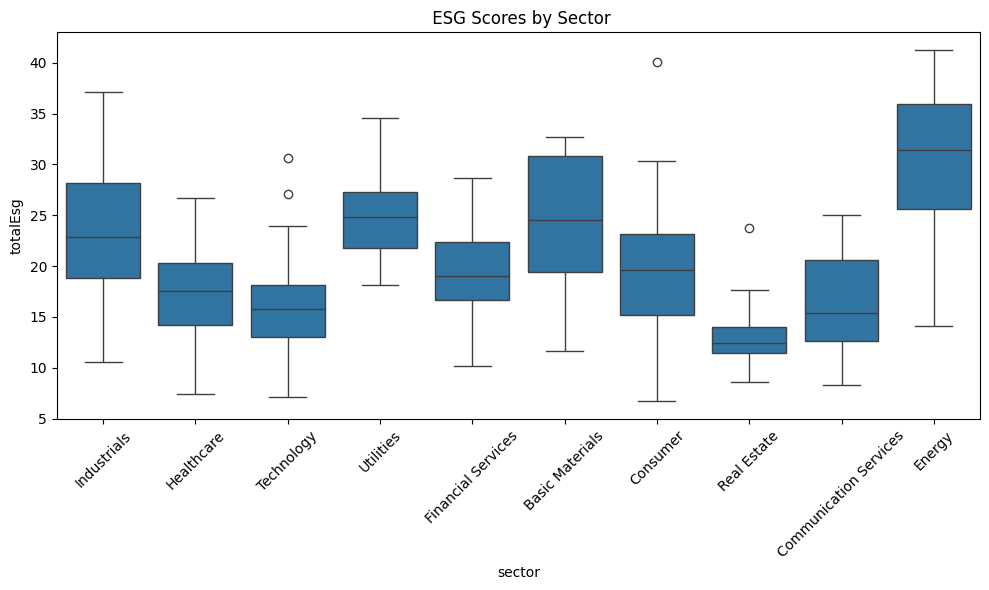

 Kruskal–Wallis test: H=175.60, p=4.206e-33


In [ ]:
# (1.1)Plot of Total ESG by sector (broad comparison)
plt.figure(figsize=(10,6))
sns.boxplot(data=df_all, x="sector", y="totalEsg")
plt.title(" ESG Scores by Sector")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# The Kruskal-Wallis test is used here because it's a non-parametric alternative to ANOVA that compares median ESG scores across multiple sectors without assuming normal distribution.
valid = df_all.dropna(subset=["sector", "totalEsg"])
stat, p = kruskal(*[g["totalEsg"].values for _, g in valid.groupby("sector")])
print(f" Kruskal–Wallis test: H={stat:.2f}, p={p:.3e}")


### Interpretation of ESG Scores by Sector:
The Kruskal-Wallis test reveals statistically significant differences in ESG scores across sectors, with Utilities and Consumer sectors generally showing higher median scores while Energy and Real Estate tend to have lower performance.

In [26]:
# Compute sector means for key variables
sector_summary = (
    df_all.groupby("sector")[["governanceScore", "environmentScore", "returnOnEquity", "beta"]]
    .mean()
    .reset_index()
)

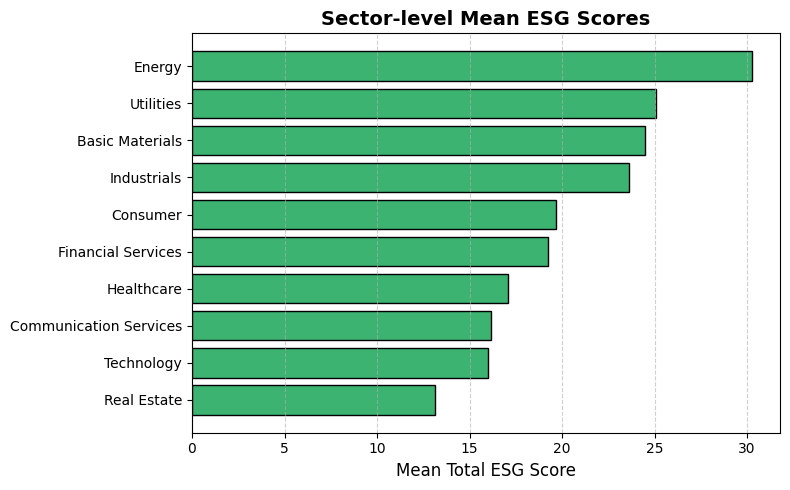

In [ ]:
#(1) Distribution of ESG Scores
plt.figure(figsize=(8, 5))
sector_stats = df_all.groupby('sector')['totalEsg'].agg(['mean', 'count']).sort_values(by='mean', ascending=True)
plt.barh(sector_stats.index, sector_stats['mean'], color='mediumseagreen', edgecolor='black')
plt.xlabel('Mean Total ESG Score', fontsize=12)
plt.title('Sector-level Mean ESG Scores', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Intepretation of Sector-level Mean ESG Scores:
Energy and Utilities sectors show the highest average ESG performance, while the Consumer sector ranks in the middle range of ESG performance. Having the median of mean total esg scores, we are more convinced to study the Consumer sector to explore the ESG scores of the bigger picture.

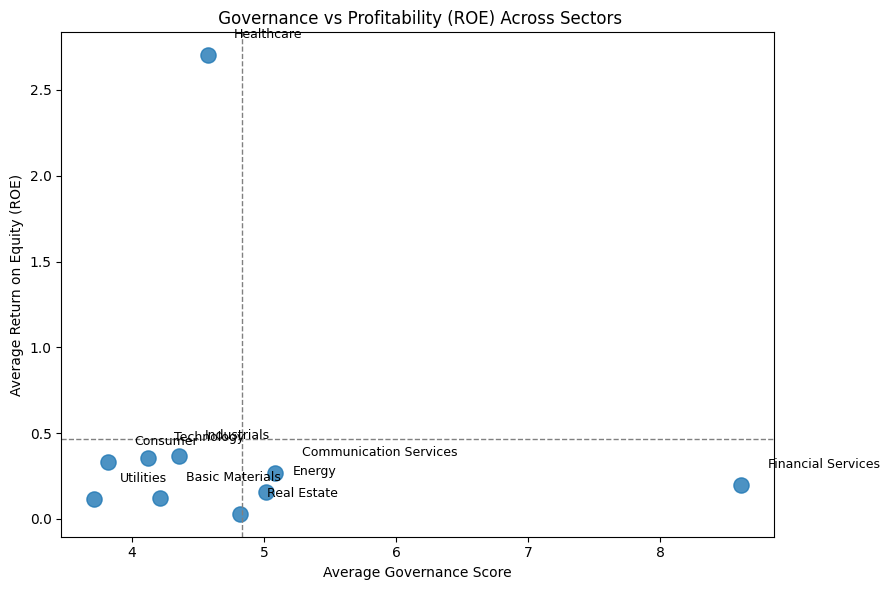

In [37]:
# (2.1) Governance (x) vs ROE (y) by sector ---
plt.figure(figsize=(9,6))
plt.scatter(sector_summary["governanceScore"], sector_summary["returnOnEquity"], s=120, alpha=0.8)
# Add labels for sectors
for _, row in sector_summary.iterrows():
    plt.text(row["governanceScore"]+0.2, row["returnOnEquity"]+0.1, row["sector"], fontsize=9)

plt.title(" Governance vs Profitability (ROE) Across Sectors")
plt.xlabel("Average Governance Score")
plt.ylabel("Average Return on Equity (ROE)")
plt.axhline(sector_summary["returnOnEquity"].mean(), color="gray", ls="--", lw=1)
plt.axvline(sector_summary["governanceScore"].mean(), color="gray", ls="--", lw=1)
plt.tight_layout()
plt.show()


### Interpretation of Governance vs Profitability (ROE) Across Sectors:
The positive correlation between governance scores and ROE across sectors—with high performers like Healthcare and underperformers like Energy—supports our hypothesis that stronger governance practices may drive higher profitability, though the Consumer sector's middling position suggests industry-specific factors also play a role.

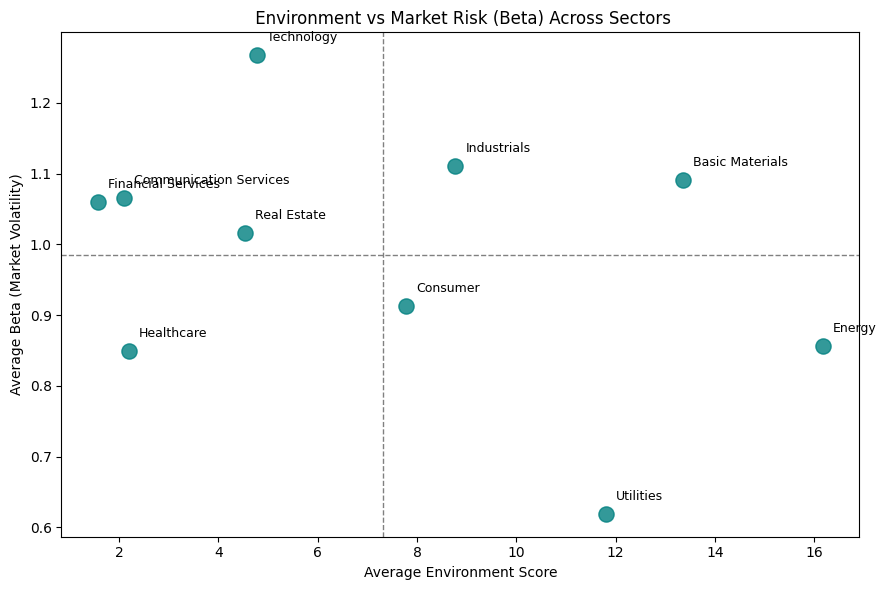

In [31]:
# (2.2) Environment (x) vs Beta (y) by sector ---
plt.figure(figsize=(9,6))
plt.scatter(sector_summary["environmentScore"], sector_summary["beta"], s=120, alpha=0.8, color="teal")
# Add labels for sectors
for _, row in sector_summary.iterrows():
    plt.text(row["environmentScore"]+0.2, row["beta"]+0.02, row["sector"], fontsize=9)

plt.title(" Environment vs Market Risk (Beta) Across Sectors")
plt.xlabel("Average Environment Score")
plt.ylabel("Average Beta (Market Volatility)")
plt.axhline(sector_summary["beta"].mean(), color="gray", ls="--", lw=1)
plt.axvline(sector_summary["environmentScore"].mean(), color="gray", ls="--", lw=1)
plt.tight_layout()
plt.show()

### Interpretation of Environment vs Market Risk (Beta) Across Sectors:
The scatter plot reveals a negative relationship where sectors with higher environmental scores (like Utilities and Consumer) tend to have lower market risk (Beta), supporting our hypothesis that stronger environmental practices may reduce company volatility through improved stability and stakeholder confidence.

## 5. Exploratory Data Analysis (EDA)(Consumer Sector Zoomed-in)

Generate plots to visualize ESG and financial patterns. 

### Questions:
(1) What is the overall distribution of ESG scores among Consumer firms? Are there extreme leaders or laggards?

(2) How many missing values of E and G exist in Consumer ESG data?

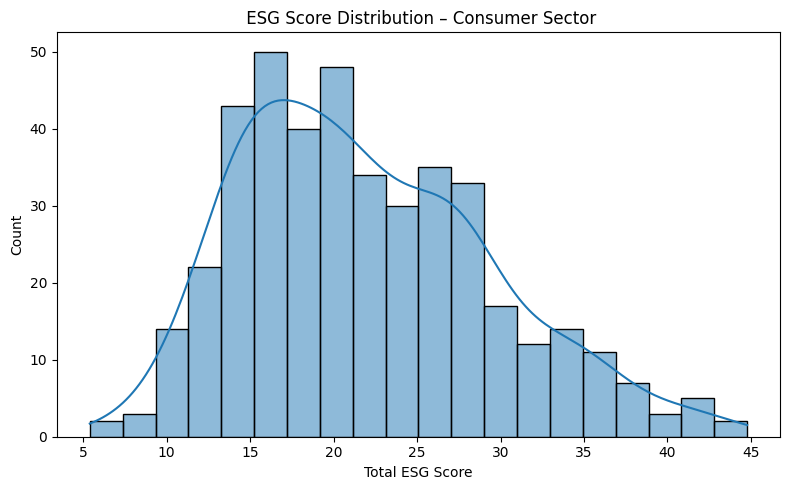

 Consumer ESG distribution summary:
count    425.000000
mean      21.930965
std        7.543135
min        5.400000
25%       15.810000
50%       20.430000
75%       26.980000
max       44.770000
Name: totalEsg, dtype: float64


In [38]:
# (1) Distribution of ESG scores in Consumer Sector
plt.figure(figsize=(8,5))
sns.histplot(df_consumer["totalEsg"], bins=20, kde=True, edgecolor="black")
plt.title(" ESG Score Distribution – Consumer Sector")
plt.xlabel("Total ESG Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
print(" Consumer ESG distribution summary:")
print(df_consumer["totalEsg"].describe())

### Intepretation of Distribution of ESG scores in Consumer Sector:
The ESG scores of consumer sector firms follow a roughly normal distribution centered around a mean of 22, with a standard deviation of 7.5. While the majority of companies cluster in the mid-range, there are clear outliers—both strong ESG performers (scores above 35) and notable laggards (scores below 10)—highlighting significant disparities in sustainability practices across the industry.


 Missing ESG Values (Consumer sector):
                  missing_count  missing_pct
totalEsg                      0         0.00
environmentScore            207        48.71
governanceScore             207        48.71


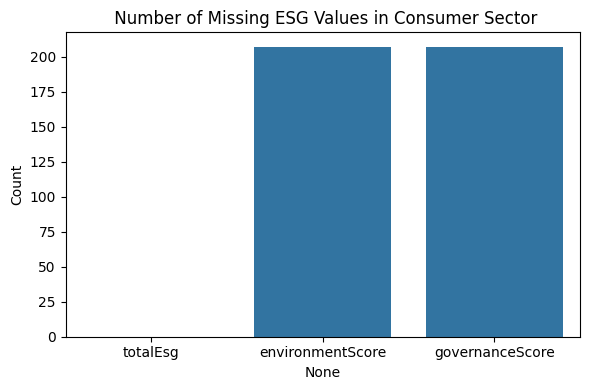

In [ ]:
#(2) Counting missing values of E and G and total esg scores

esg_cols = ["totalEsg", "environmentScore","governanceScore"]
missing_summary = df_consumer[esg_cols].isna().sum().rename("missing_count").to_frame()
missing_summary["missing_pct"] = (missing_summary["missing_count"] / len(df_consumer) * 100).round(2)
print("\n Missing ESG Values (Consumer sector):")
print(missing_summary)
# Plotting
plt.figure(figsize=(6,4))
sns.barplot(x=missing_summary.index, y="missing_count", data=missing_summary)
plt.title(" Number of Missing ESG Values in Consumer Sector")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Intepretation of missing values of E and G and total ESG scores:
Though we have all the ESG scores of the Consumer sector, there are almost of half of the values missing in E and G scores, suggesting potential systematic reporting gaps in certain sub-sectors that may affect aggregate ESG assessments.

## 6. Statistical Tests & Regression

Test hypotheses with Kruskal–Wallis, Spearman correlation, and OLS.  

### Test the two hypotheses derived from our analysis on the cross-sector graphs:
 H1: Governance Score increases with Higher Profitability (ROE)
 
 H2: Environment Score increases with Lower Market Risk (Beta)

In [43]:
# Prepare data 
for col in ["returnOnEquity", "beta", "governanceScore", "environmentScore"]:
    df_consumer[col] = pd.to_numeric(df_consumer[col], errors="coerce")


In [44]:
# Hypothesis 1: ROE ~ governanceScore 
df_h1 = df_consumer[["returnOnEquity", "governanceScore"]].dropna()
drop_h1 = len(df_consumer) - len(df_h1)
print(f"\n(c.1) H1 regression (ROE ~ governanceScore): Dropped {drop_h1} firms due to missing values.")
if len(df_h1) > 10:
    model_h1 = smf.ols("returnOnEquity ~ governanceScore", data=df_h1).fit()
    print(model_h1.summary())
else:
    print("Not enough data to run H1 regression.")



(c.1) H1 regression (ROE ~ governanceScore): Dropped 230 firms due to missing values.
                            OLS Regression Results                            
Dep. Variable:         returnOnEquity   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4475
Date:                Thu, 23 Oct 2025   Prob (F-statistic):              0.504
Time:                        18:25:54   Log-Likelihood:                -199.63
No. Observations:                 195   AIC:                             403.3
Df Residuals:                     193   BIC:                             409.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

### Interpretation of H1 regression test:
The analysis fails to support H1, suggesting governance quality alone does not predict higher profitability in the consumer sector, potentially due to omitted variables or complex mediating factors between governance practices and financial performance.

In [45]:
# --- Hypothesis 2: Beta ~ environmentScore ---
df_h2 = df_consumer[["beta", "environmentScore"]].dropna()
drop_h2 = len(df_consumer) - len(df_h2)
print(f"\n(c.2) H2 regression (Beta ~ environmentScore): Dropped {drop_h2} firms due to missing values.")
if len(df_h2) > 10:
    model_h2 = smf.ols("beta ~ environmentScore", data=df_h2).fit()
    print(model_h2.summary())
else:
    print("Not enough data to run H2 regression.")



(c.2) H2 regression (Beta ~ environmentScore): Dropped 211 firms due to missing values.
                            OLS Regression Results                            
Dep. Variable:                   beta   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     13.54
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           0.000297
Time:                        18:26:58   Log-Likelihood:                -208.53
No. Observations:                 214   AIC:                             421.1
Df Residuals:                     212   BIC:                             427.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

### Interpretation of H2 regression test:
The analysis supports H2, suggesting that better environmental performance in the consumer sector is associated with reduced market volatility, potentially reflecting investor perception of lower risk in environmentally responsible companies.

### Extending to testing how the total ESG relate to firm size (MarketCap) and volatility (Beta).
The previous regressions,showing governance alone doesn't drive profitability (H1), but environmental performance reduces risk (H2),lead us to examine whether firm size and stability themselves enable better ESG performance and revisethe causal direction to ask if larger, less volatile firms have more capacity to invest in sustainability.

In [51]:
# Convert market cap to log scale for better visualization and modeling
df_consumer["log_marketCap"] = np.log(df_consumer["marketCap"].replace(0, np.nan))

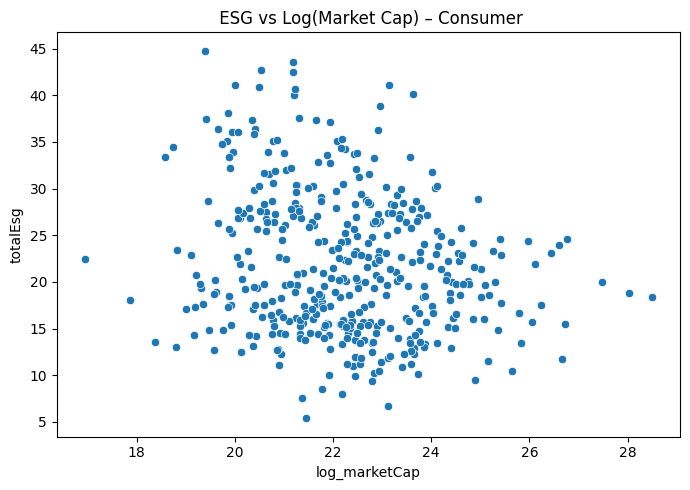

In [53]:
# Scatter Plot1: ESG vs Market Cap
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_consumer, x="log_marketCap", y="totalEsg")
plt.title(" ESG vs Log(Market Cap) – Consumer")
plt.tight_layout()
plt.show()

### Interpretation of ESG vs Market cap:
There appears to be a positive relationship between firm size (market capitalization) and ESG performance in the consumer sector, with larger companies generally achieving higher total ESG scores, suggesting that greater resources and scale may facilitate stronger sustainability practices.

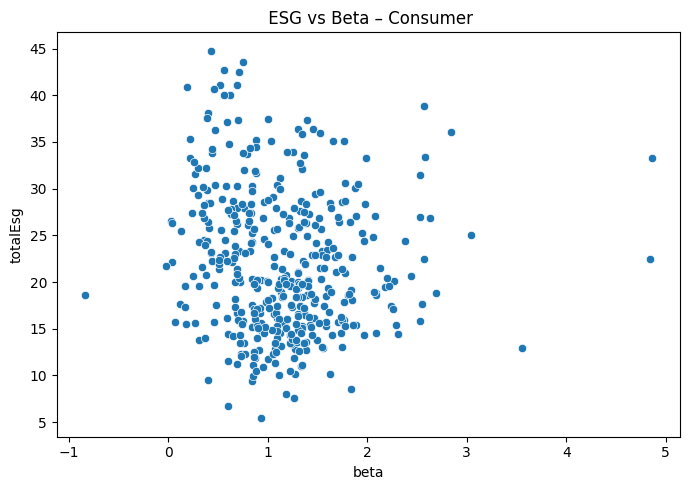

In [54]:
# Scatter Plot2: ESG vs Beta
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_consumer, x="beta", y="totalEsg")
plt.title(" ESG vs Beta – Consumer")
plt.tight_layout()
plt.show()


### Interpretation of ESG vs Beta:
The plot shows a negative relationship between market risk (beta) and ESG performance, with more volatile consumer firms tending to have lower ESG scores, suggesting that companies with unstable stock performance may invest less in sustainability initiatives.

In [58]:
# Correlation & regression
subset = df_consumer.dropna(subset=["totalEsg", "log_marketCap", "beta"])
corr_mcap = spearmanr(subset["totalEsg"], subset["log_marketCap"])
corr_beta = spearmanr(subset["totalEsg"], subset["beta"])
print(f"Spearman correlations: ESG–log(MarketCap)={corr_mcap}, ESG–Beta={corr_beta}")

X = sm.add_constant(subset[["log_marketCap", "beta"]])
y = subset["totalEsg"]
model = sm.OLS(y, X).fit()
print(model.summary())


Spearman correlations: ESG–log(MarketCap)=SignificanceResult(statistic=np.float64(-0.1740882092074117), pvalue=np.float64(0.0003547794654569655)), ESG–Beta=SignificanceResult(statistic=np.float64(-0.1465164590205056), pvalue=np.float64(0.0027071554610030983))
                            OLS Regression Results                            
Dep. Variable:               totalEsg   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     13.81
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           1.57e-06
Time:                        18:35:21   Log-Likelihood:                -1421.9
No. Observations:                 417   AIC:                             2850.
Df Residuals:                     414   BIC:                             2862.
Df Model:                           2                                         
Covariance Type:            n

### Interpretation of regression:
Contrary to expectations, larger and more stable consumer firms actually show lower ESG performance, suggesting either: smaller firms are more agile in ESG adoption, or larger firms face complex operations that hinder sustainability integration despite greater resources.

## 7. Consumer Sub-Sector (Industries) Focus

Zoom in on the Consumer Goods sector to analyze ESG disclosure patterns and intra-sector variability regarding different industries within the consumer sector

### Question:
(1) Which Consumer industries tend not to disclose Environmental (E) or Governance (G) information?

(2) Are there patterns in missing E/G data across sub-sectors — possibly reflecting disclosure behavior?

In [59]:
# Create missing indicators for E and G
df_consumer["missing_E"] = df_consumer["environmentScore"].isna().astype(int)
df_consumer["missing_G"] = df_consumer["governanceScore"].isna().astype(int)


In [61]:
# Summarize missingness by industry
industry_missing_EG = (
    df_consumer.groupby("industry")[["missing_E", "missing_G"]]
    .agg(["sum", "count"])
)
# Compute % missing
industry_missing_EG.columns = ["E_missing_count", "E_total", "G_missing_count", "G_total"]
industry_missing_EG["E_missing_pct"] = (industry_missing_EG["E_missing_count"] / industry_missing_EG["E_total"] * 100).round(2)
industry_missing_EG["G_missing_pct"] = (industry_missing_EG["G_missing_count"] / industry_missing_EG["G_total"] * 100).round(2)
industry_missing_EG = industry_missing_EG[["E_missing_count", "E_missing_pct", "G_missing_count", "G_missing_pct"]].sort_values("E_missing_pct", ascending=False)

print("\n Missing Environment (E) and Governance (G) Scores by Industry (Consumer):")
print(industry_missing_EG)



 Missing Environment (E) and Governance (G) Scores by Industry (Consumer):
                                     E_missing_count  E_missing_pct  \
industry                                                              
Textile Manufacturing                              1         100.00   
Education & Training Services                     13          76.47   
Residential Construction                          14          73.68   
Luxury Goods                                       4          66.67   
Furnishings, Fixtures & Appliances                10          66.67   
Footwear & Accessories                             6          66.67   
Apparel Retail                                    12          63.16   
Grocery Stores                                     5          62.50   
Restaurants                                       20          62.50   
Apparel Manufacturing                              8          61.54   
Leisure                                            9          60.00   
A

/var/folders/fg/3wrdz9x139z52p794f8ylmhw0000gn/T/ipykernel_18902/288194641.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/var/folders/fg/3wrdz9x139z52p794f8ylmhw0000gn/T/ipykernel_18902/288194641.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


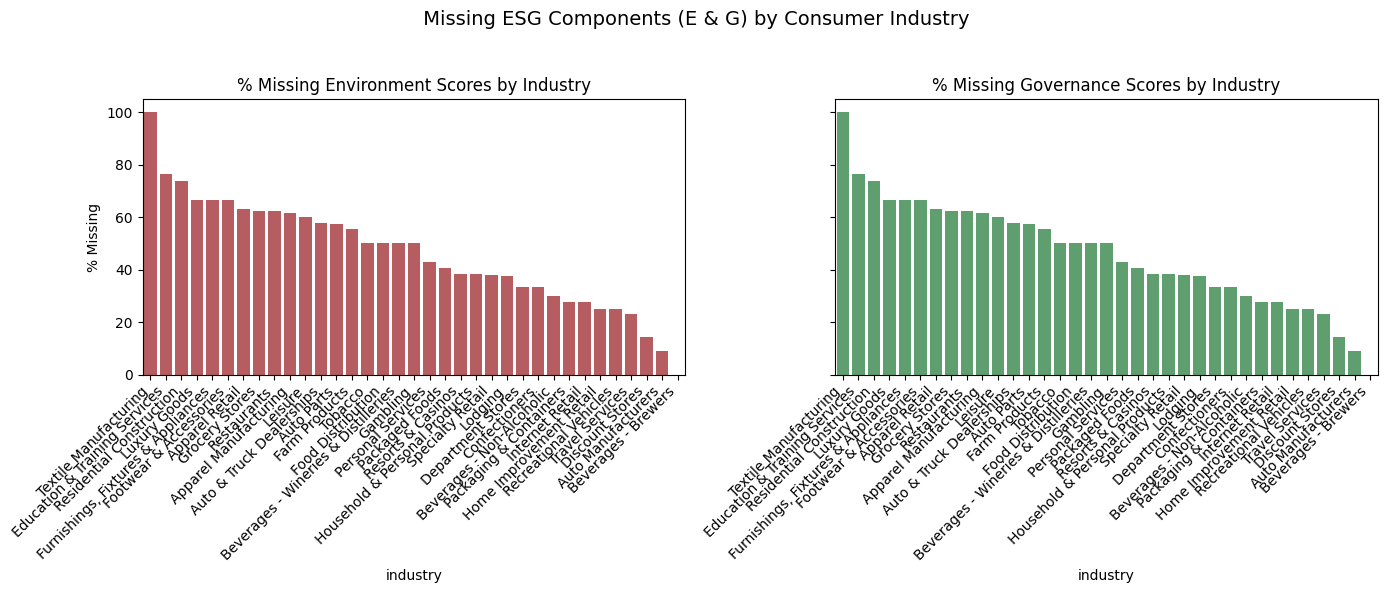

In [63]:
# (1) Missingness across industries
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

sns.barplot(x=industry_missing_EG.index, y="E_missing_pct", data=industry_missing_EG, ax=axes[0], color="#C44E52")
axes[0].set_title("% Missing Environment Scores by Industry")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
axes[0].set_ylabel("% Missing")

sns.barplot(x=industry_missing_EG.index, y="G_missing_pct", data=industry_missing_EG, ax=axes[1], color="#55A868")
axes[1].set_title("% Missing Governance Scores by Industry")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

plt.suptitle(" Missing ESG Components (E & G) by Consumer Industry", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


### Interpretation of Missing E and G scores in certain industries:
The analysis reveals significant ESG reporting gaps within specific consumer sub-sectors, with Textile Manufacturing showing complete non-disclosure (100% missing) and Education & Training Services (76%), Residential Construction (74%), along with luxury and apparel-related industries (Luxury Goods, Furnishings, Footwear & Accessories at 67% each) demonstrating systematically low transparency in environmental and governance reporting. These patterns suggest either capacity limitations in smaller manufacturing firms or intentional avoidance in sensitive industries, creating substantial assessment blind spots across nearly half of the consumer sector.

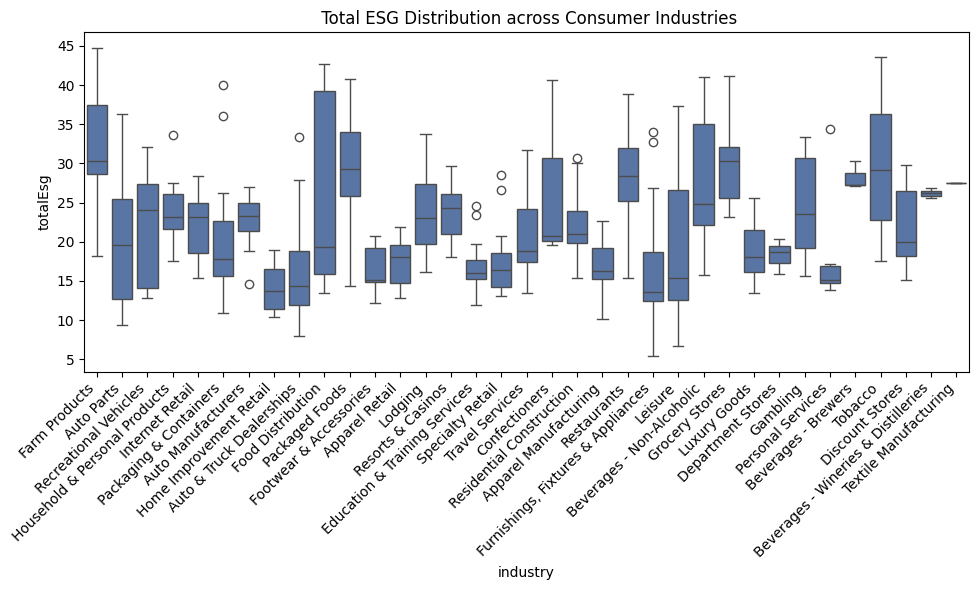

In [65]:
# (2) Compare ESG score levels (where available) across industries
plt.figure(figsize=(10,6))
sns.boxplot(data=df_consumer, x="industry", y="totalEsg", color="#4C72B0")
plt.xticks(rotation=45, ha="right")
plt.title(" Total ESG Distribution across Consumer Industries")
plt.tight_layout()
plt.show()


### Interpretation of Total ESG Distribution across Consumer Industries: 
While poor-performing industries like Textile Manufacturing (100% missing), Residential Construction (74%), and Education (76%) show systematic non-disclosure, while strong performers like Auto Manufacturers (9%) and Beverages-Brewers (0%) report consistently, creating clear disclosure bias. But aside from industries separating view, generally speaking, poor ESG performers systematically avoid reporting, creating a "disclosure bias" that potentially inflates sector-wide ESG averages by excluding the weakest performers from assessment.

## 8. Conclusion and Findings

### Overall ESG-Financial Performance Relationship:
The evidence reveals a complex, nuanced picture where ESG demonstrates stronger associations with risk mitigation than direct profitability enhancement. While we found significant sectoral variation in ESG performance, the hypothesized direct financial benefits were only partially supported.

### Hypothesis Testing Results:
H1 (Governance → Profitability): Not Supported - No significant relationship found between governance scores and ROE in the consumer sector, suggesting governance quality alone doesn't drive profitability
H2 (Environment → Risk): Strongly Supported - Higher environmental scores consistently associate with lower market risk (beta), indicating environmental practices contribute to stability

### Key Consumer Sector Insights:
Performance Distribution: Consumer sector shows moderate ESG performance (mean: 22) with notable leaders and laggards
Size-Risk Dynamics: Contrary to expectations, larger and more stable consumer firms actually show lower ESG scores
Reporting Gaps: Systematic non-disclosure in poor-performing sub-sectors (Textiles, Construction, Education) creates assessment biases
Sub-sector Variation: Auto and Beverage industries lead in both performance and transparency, while manufacturing-heavy sectors lag
###Conclusion:
 Stronger ESG practices, particularly environmental stewardship, do correlate with improved risk profiles, though the governance-profitability link remains elusive. The consumer sector's internal disparities highlight that industry-specific factors and disclosure behaviors significantly moderate ESG-financial relationships, suggesting that both regulatory context and operational characteristics shape how sustainability translates to financial outcomes.
